# Product Engagement Analysis

This notebook uses `analytics.analytics.fct_product_daily_engagement` to explore **product-level engagement patterns** with a product/PM lens.

**Key questions**
- Is engagement concentrated among a small number of products?
- Which products show sustained vs episodic usage?
- Which follow-up questions require product metadata to answer well?

> This notebook stays at the product (`lp_id`) level until product metadata is wired in.

In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- plotting defaults ----
plt.rcParams["figure.figsize"] = (10, 5)

# ---- connect ----
DB_PATH = "../warehouse/edtech_engagement.duckdb"
con = duckdb.connect(DB_PATH)

def q(sql: str) -> pd.DataFrame:
    """Run a SQL query against DuckDB and return a DataFrame."""
    return con.execute(sql).df()

def pct(n, d) -> float:
    return (float(n) / float(d) * 100.0) if d else 0.0

def sql_in_list(values):
    """Create a safe-ish SQL IN (...) list for simple ints/strings."""
    lits = []
    for v in values:
        if v is None:
            continue
        if isinstance(v, (int, np.integer)):
            lits.append(str(int(v)))
        else:
            s = str(v).replace("'", "''")
            lits.append("'" + s + "'")
    return "(" + ",".join(lits) + ")" if lits else "(NULL)"

con

## 1. Inspect available tables

In [2]:
q("""
SELECT table_schema, table_name
FROM information_schema.tables
WHERE table_schema = 'analytics'
ORDER BY table_name
""")

,table_schema,table_name
0,analytics,dim_products
1,analytics,fct_daily_engagement
2,analytics,fct_daily_engagement_unknown_product
3,analytics,fct_product_daily_engagement
4,analytics,my_first_dbt_model
5,analytics,my_second_dbt_model
6,analytics,raw_districts
7,analytics,raw_engagement
8,analytics,raw_products
9,analytics,stg_districts


## 2. Preview `analytics.analytics.fct_product_daily_engagement`

In [3]:
q("""
SELECT *
FROM analytics.fct_product_daily_engagement
LIMIT 10
""")

,lp_id,usage_date,avg_pct_access,avg_engagement_index
0,55007,2020-05-20,0.080,0.840
1,58235,2020-05-20,0.070,19.530
2,86575,2020-05-20,0.070,8.435
3,47368,2020-05-21,0.170,24.430
4,81189,2020-05-21,0.515,174.720
5,55450,2020-05-28,0.440,29.800
6,86812,2020-05-30,0.080,4.210
7,90153,2020-06-01,0.185,5.500
8,40159,2020-06-08,0.080,3.370
9,91165,2020-06-10,0.085,3.430


## 3. Product coverage in the fact table

In [4]:
product_coverage = q("""
SELECT
    COUNT(*) AS n_rows,
    COUNT(DISTINCT lp_id) AS n_products,
    SUM(CASE WHEN lp_id IS NULL THEN 1 ELSE 0 END) AS n_missing_lp_id
FROM analytics.fct_product_daily_engagement
""")
product_coverage

,n_rows,n_products,n_missing_lp_id
0,153864,4822,0.0


In [5]:
n_rows = int(product_coverage.loc[0, "n_rows"])
n_missing = int(product_coverage.loc[0, "n_missing_lp_id"])
print(f"Rows: {n_rows:,}")
print(f"Rows missing lp_id: {n_missing:,} ({pct(n_missing, n_rows):.2f}%)")

Rows: 153,864
Rows missing lp_id: 0 (0.00%)


## 4. Engagement concentration (Pareto-style)

We compute each product's share of total engagement and examine how quickly the cumulative share rises.

If a small number of products account for most engagement, that suggests a “winner-take-most” usage pattern.

In [6]:
shares = q("""
WITH per_product AS (
    SELECT
        lp_id,
        SUM(avg_engagement_index) AS total_engagement
    FROM analytics.fct_product_daily_engagement
    WHERE lp_id IS NOT NULL AND avg_engagement_index IS NOT NULL
    GROUP BY 1
),
totals AS (
    SELECT SUM(total_engagement) AS all_engagement FROM per_product
)
SELECT
    p.lp_id,
    p.total_engagement,
    p.total_engagement / t.all_engagement AS engagement_share
FROM per_product p
CROSS JOIN totals t
ORDER BY p.total_engagement DESC
""")
shares.head(10)

,lp_id,total_engagement,engagement_share
0,95731,2.212675e+06,0.170834
1,32213,1.621244e+06,0.125172
2,26488,1.205004e+06,0.093035
3,47364,9.315363e+05,0.071921
4,98845,5.718657e+05,0.044152
5,24711,5.328236e+05,0.041138
6,92993,4.149969e+05,0.032041
7,61292,3.942403e+05,0.030438
8,33185,2.610379e+05,0.020154
9,25559,2.488212e+05,0.019211


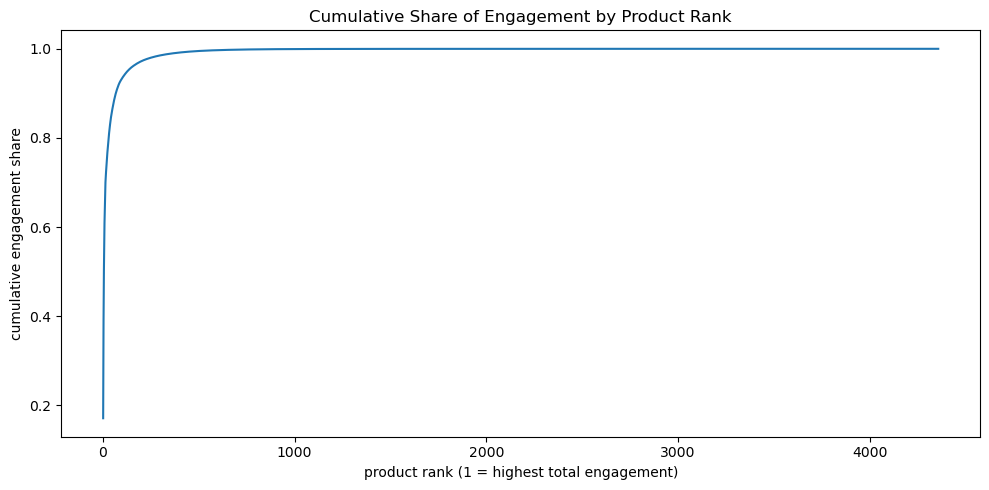

Top 1 products account for 17.1% of total engagement
Top 3 products account for 38.9% of total engagement
Top 5 products account for 50.5% of total engagement
Top 10 products account for 64.8% of total engagement
Top 20 products account for 74.9% of total engagement


In [7]:
# Cumulative share curve
shares = shares.copy()
shares["rank"] = range(1, len(shares) + 1)
shares["cum_share"] = shares["engagement_share"].cumsum()

plt.plot(shares["rank"], shares["cum_share"])
plt.title("Cumulative Share of Engagement by Product Rank")
plt.xlabel("product rank (1 = highest total engagement)")
plt.ylabel("cumulative engagement share")
plt.tight_layout()
plt.show()

# Quick readouts
for n in [1, 3, 5, 10, 20]:
    if len(shares) >= n:
        print(f"Top {n} products account for {shares.loc[n-1, 'cum_share']*100:.1f}% of total engagement")

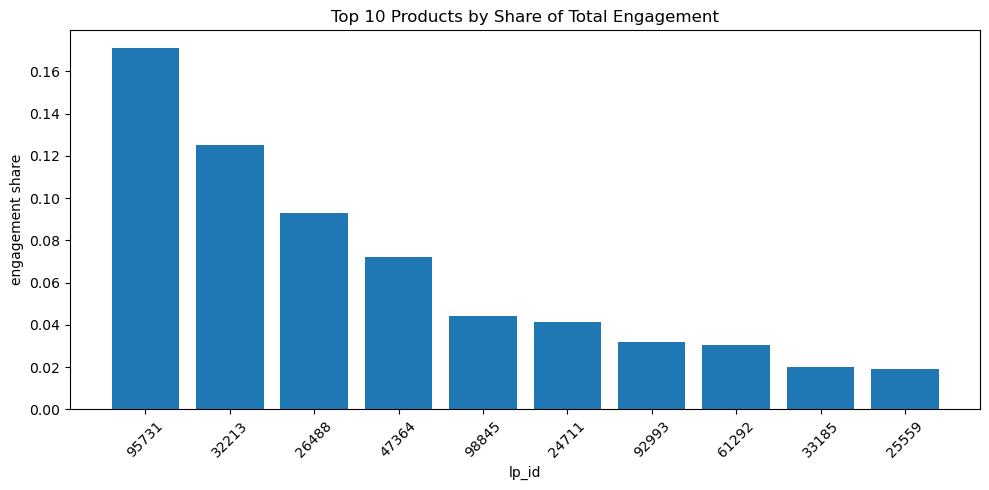

,lp_id,total_engagement,engagement_share
0,95731,2.212675e+06,0.170834
1,32213,1.621244e+06,0.125172
2,26488,1.205004e+06,0.093035
3,47364,9.315363e+05,0.071921
4,98845,5.718657e+05,0.044152
5,24711,5.328236e+05,0.041138
6,92993,4.149969e+05,0.032041
7,61292,3.942403e+05,0.030438
8,33185,2.610379e+05,0.020154
9,25559,2.488212e+05,0.019211


In [8]:
top10 = shares.head(10)
plt.bar(top10["lp_id"].astype(str), top10["engagement_share"])
plt.title("Top 10 Products by Share of Total Engagement")
plt.xlabel("lp_id")
plt.ylabel("engagement share")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

top10[["lp_id", "total_engagement", "engagement_share"]]

## 5. Volatility vs average engagement

A helpful mental model is to look at **average engagement** and **volatility** together. This can separate:
- high & stable (sustained, high-use)
- high & volatile (spiky, episodic)
- low & stable (steady low usage)
- low & volatile (inconsistent/rare usage)

This is exploratory — interpretation improves once we have product metadata.

In [9]:
metrics = q("""
SELECT
  lp_id,
  COUNT(*) AS n_days,
  AVG(avg_engagement_index) AS avg_engagement,
  STDDEV_POP(avg_engagement_index) AS engagement_volatility
FROM analytics.fct_product_daily_engagement
WHERE lp_id IS NOT NULL AND avg_engagement_index IS NOT NULL
GROUP BY 1
HAVING COUNT(*) >= 30
""")
metrics.describe()

,lp_id,n_days,avg_engagement,engagement_volatility
count,881.000000,881.000000,881.000000,881.000000
mean,54637.659478,115.753689,53.668676,69.755008
std,26411.276364,85.160047,322.617050,372.777068
min,10084.000000,30.000000,0.159500,0.110562
25%,31669.000000,51.000000,1.702149,2.466641
50%,53775.000000,85.000000,4.843289,8.205259
75%,77698.000000,157.000000,17.627500,29.226070
max,99984.000000,366.000000,6045.558825,7022.054576


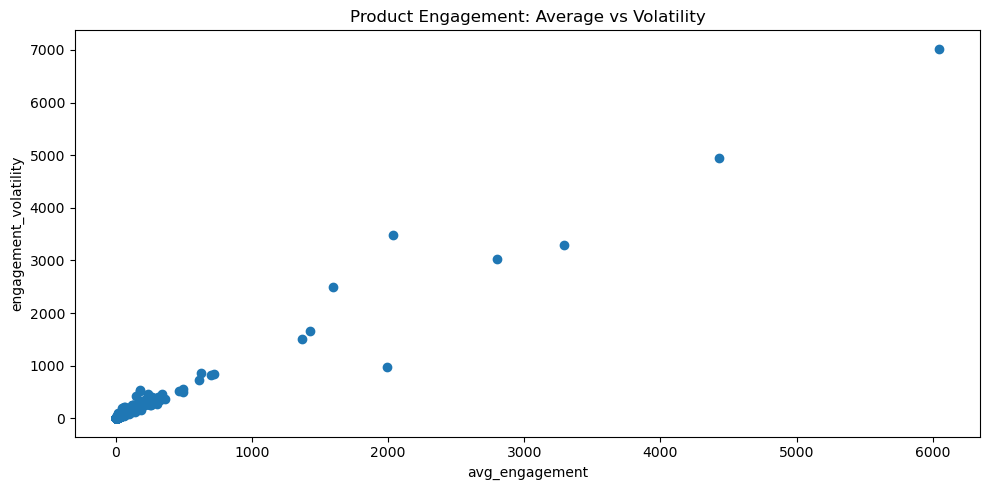

,lp_id,n_days,avg_engagement,engagement_volatility
719,95731,366,6045.558825,7022.054576
820,32213,366,4429.628188,4954.613528
358,98845,281,2035.109164,3480.984341
771,26488,366,3292.359458,3285.251750
248,47364,333,2797.406286,3035.150758
617,24711,335,1590.518214,2495.542076
85,47368,157,1428.268599,1654.543406
80,92993,303,1369.626623,1500.524046
196,61292,198,1991.112727,970.439622
4,99916,366,625.876293,864.510498


In [10]:
plt.scatter(metrics["avg_engagement"], metrics["engagement_volatility"])
plt.title("Product Engagement: Average vs Volatility")
plt.xlabel("avg_engagement")
plt.ylabel("engagement_volatility")
plt.tight_layout()
plt.show()

metrics.sort_values("engagement_volatility", ascending=False).head(10)

## 6. Example drill-down: one volatile vs one stable product

We pick one highly volatile product and one low-volatility product, then plot their engagement over time.

(If you have product names later, these charts get much more interpretable.)

In [11]:
most_vol_id = metrics.sort_values("engagement_volatility", ascending=False)["lp_id"].iloc[0]
least_vol_id = metrics.sort_values("engagement_volatility", ascending=True)["lp_id"].iloc[0]
most_vol_id, least_vol_id

(np.int64(95731), np.int64(13508))

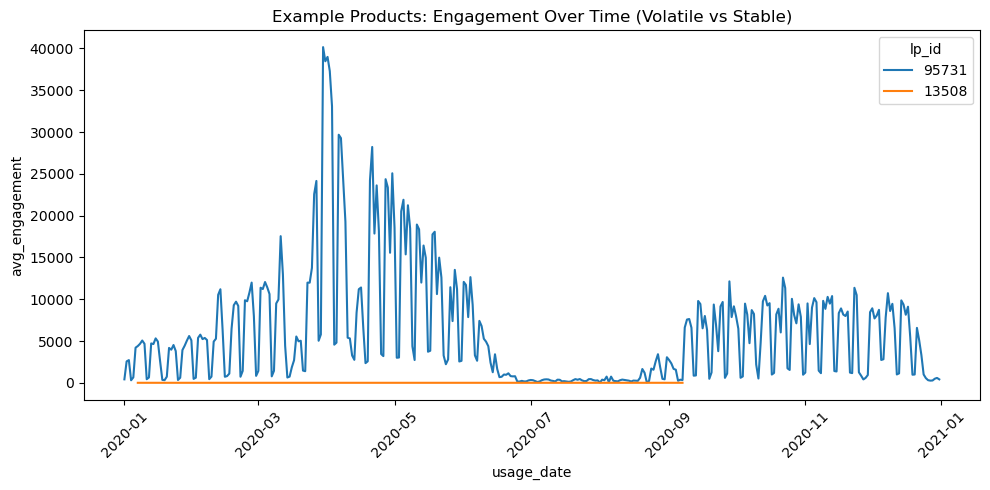

In [12]:
example_ids = [most_vol_id, least_vol_id]
in_list = sql_in_list(example_ids)

ex_trend = q(f"""
SELECT
    usage_date,
    lp_id,
    AVG(avg_engagement_index) AS avg_engagement
FROM analytics.fct_product_daily_engagement
WHERE lp_id IN {in_list} AND avg_engagement_index IS NOT NULL
GROUP BY 1, 2
ORDER BY 1, 2
""")

for lp_id in example_ids:
    s = ex_trend[ex_trend["lp_id"] == lp_id]
    plt.plot(s["usage_date"], s["avg_engagement"], label=str(lp_id))

plt.title("Example Products: Engagement Over Time (Volatile vs Stable)")
plt.xlabel("usage_date")
plt.ylabel("avg_engagement")
plt.xticks(rotation=45)
plt.legend(title="lp_id")
plt.tight_layout()
plt.show()

In [13]:
con.close()

## 7. Product metadata join (planned)

At this point, we intentionally stop short of attributing *why* a product looks spiky or steady.

**Next step in the pipeline:** add a product dimension table (e.g., subject, grade, instructional type, platform) and join it to `lp_id`.

Once that exists, analyses like these become much more valuable:
- Engagement concentration by subject/category
- Volatility by instructional type (core vs assessment vs supplemental)
- Cohort differences (school/teacher/grade) to separate system-wide patterns from localized adoption
- “New product adoption” curves (time since launch / rollout)

For now, these results should be treated as signals that guide where to look next, not as final conclusions.
